In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from astropy.io import fits

import sys
sys.path.insert(0, "../")

import velociraptor
from mpl_utils import mpl_style

%matplotlib inline
plt.style.use(mpl_style)

In [2]:
data = fits.open("../data/rv-all.fits")[1].data

In [119]:
def get_rv_completeness(label_name, semilogx, equidensity, N_bins,
                        x_min=None, x_max=None):

    x = data[label_name]
    y = data["radial_velocity"]
    
    x_finite = np.isfinite(x)
    y_finite = np.isfinite(y)
    finite = x_finite * y_finite
    if x_min is None:
        x_min = np.min(x[x_finite])
    if x_max is None:
        x_max = np.max(x[x_finite])
    
    mask = (x_max >= x) * (x >= x_min)
    x_finite *= mask
    y_finite *= mask
    
    p = np.linspace(0, 100, N_bins)
    if equidensity and semilogx:
        bins = 10**np.percentile(np.log10(x[x_finite]), p)
        
    elif equidensity and not semilogx:
        bins = np.percentile(x[x_finite], p)
    
    elif not equidensity and semilogx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), N_bins)
    
    elif not equidensity and not semilogx:
        bins = np.linspace(x_min, x_max, N_bins)
    
    numerator, _ = np.histogram(x[x_finite * y_finite], bins=bins)
    denominator, _ = np.histogram(x[x_finite], bins=bins)
    f = numerator/denominator.astype(float)
    
    f_err = f / np.diff(bins)[0] * np.sqrt(
            (np.sqrt(numerator)/numerator)**2 + \
            (np.sqrt(denominator)/denominator)**2)
    
    return (bins, f, f_err, numerator, denominator)

In [129]:
def plot_rv_completeness(label_name, latex_label_name, semilogx,
                         equidensity, N_bins, ax=None, title=None,
                         x_min=None, x_max=None, valid_xrange=None,
                         **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.figure
        
    bins, f, f_err, num, den = get_rv_completeness(
        label_name, semilogx=semilogx, equidensity=equidensity,
        N_bins=N_bins, x_min=x_min, x_max=x_max)
    
    x = np.hstack([bins[0], np.repeat(bins[1:-1], 2), bins[-1]])
    x_mid = bins[:-1] + 0.5 * np.diff(bins)
    
    y = np.array(f).repeat(2)
    
    kwds = dict(linestyle="-", marker="None")
    kwds.update(kwargs)
    
    line = ax.plot(x, y, **kwds)
    ax.errorbar(x_mid, f, yerr=f_err, fmt="none", c=line[0].get_color())
    
    ax.set_ylabel(r"\textrm{fraction of sources with radial velocity}")
    ax.set_xlabel(latex_label_name)
    
    if semilogx:
        ax.semilogx()
        
    if valid_xrange is not None:
        lower, upper = valid_xrange
        ax.axvspan(lower, upper, facecolor="#eeeeee", edgecolor="None", zorder=-1)
    
    return fig

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


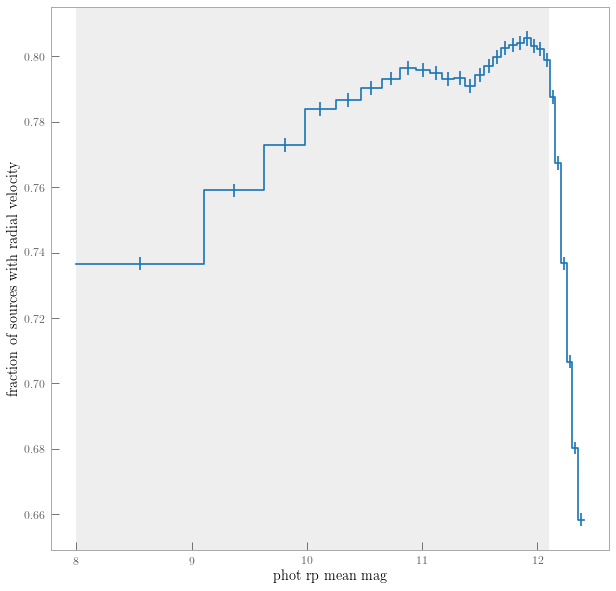

In [135]:
fig = plot_rv_completeness("phot_rp_mean_mag", r"\textrm{phot rp mean mag}",
                           semilogx=False, equidensity=True, N_bins=30,
                           x_min=8, x_max=12.4, valid_xrange=(8, 12.1))

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


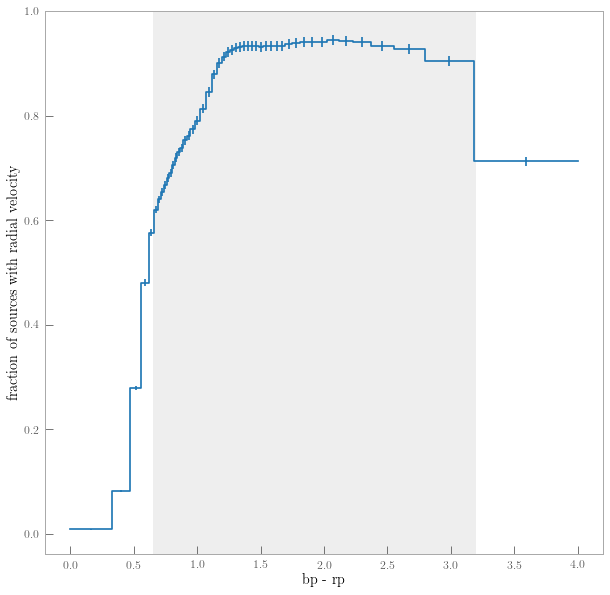

In [177]:
fig = plot_rv_completeness("bp_rp", r"\textrm{bp - rp}",
                           semilogx=False, equidensity=True, N_bins=50,
                           x_min=0, x_max=4, valid_xrange=(0.65, 3.2))

In [178]:
# Apply ranges
valid_ranges = [
    ("bp_rp", 0.65, 3.2),
    ("phot_rp_mean_mag", None, 12.1)
]

in_sb2_source_parameter_range = np.ones(len(data), dtype=bool)
for label_name, lower_value, upper_value in valid_ranges:
    if lower_value is not None:
        in_sb2_source_parameter_range *= (data[label_name] >= lower_value)
    
    if upper_value is not None:
        in_sb2_source_parameter_range *= (upper_value >= data[label_name])
        
finite_rv = np.isfinite(data["radial_velocity"])
is_sb2 = in_sb2_source_parameter_range * ~finite_rv

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


In [179]:
N_in_sb2_sp_range = sum(in_sb2_source_parameter_range)
N_is_sb2 = sum(is_sb2)

In [180]:
print("""
Total sources in valid SB2 range: {0:.0f}
Numer of sources in that range without an RV: {1:.0f}
""".format(N_in_sb2_sp_range, N_is_sb2))


Total sources in valid SB2 range: 5126507
Numer of sources in that range without an RV: 672782



In [181]:
data["absolute_g_mag"] = data["phot_g_mean_mag"] \
                       + 5 * np.log10(data["parallax"]/100.0)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [269]:
# Plot them across the H-R diagram.

def plot_density_fraction(x_label_name, y_label_name, N_bins=150, 
                          min_points_per_bin=5, x_min=None, x_max=None, 
                          y_min=None, y_max=None, ax=None, xlabel=None, 
                          ylabel=None, figsize=(8, 8), colorbar=True,
                          **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
        
    x, y = (data[x_label_name], data[y_label_name])

    finite = np.isfinite(x * y)
    if x_min is not None:
        finite *= (x >= x_min)
    if x_max is not None:
        finite *= (x_max >= x)
    if y_min is not None:
        finite *= (y >= y_min)
    if y_max is not None:
        finite *= (y_max >= y)

    den = finite * in_sb2_source_parameter_range
    num = is_sb2 * den

    H_all, xedges, yedges = np.histogram2d(x[den], y[den],
        bins=N_bins)

    H_bin, _, __ = np.histogram2d(x[num], y[num],
        bins=(xedges, yedges))


    H = H_bin/H_all.astype(float)
    H[H_all < min_points_per_bin] = np.nan

    kwds = dict(
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
    )
    kwds.update(kwargs)

    image = ax.imshow(H.T, **kwds)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)  

    if colorbar:
        cax = fig.add_axes([0.90, 0.125, 0.05, 0.75])

        cbar = plt.colorbar(image, cax=cax, orientation="vertical")
        cbar.set_label(r"\textrm{fraction of likely sb2-type systems}")
    
    return fig


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


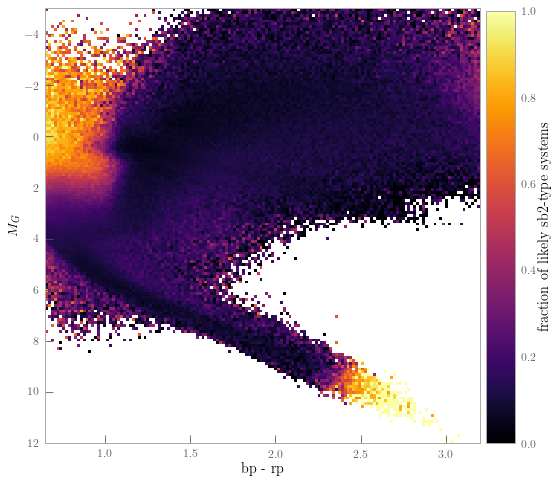

In [270]:
fig = plot_density_fraction("bp_rp", "absolute_g_mag", 
                            N_bins=150, y_min=-5, y_max=12,
                            xlabel=r"\textrm{bp - rp}", ylabel=r"$M_G$")


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


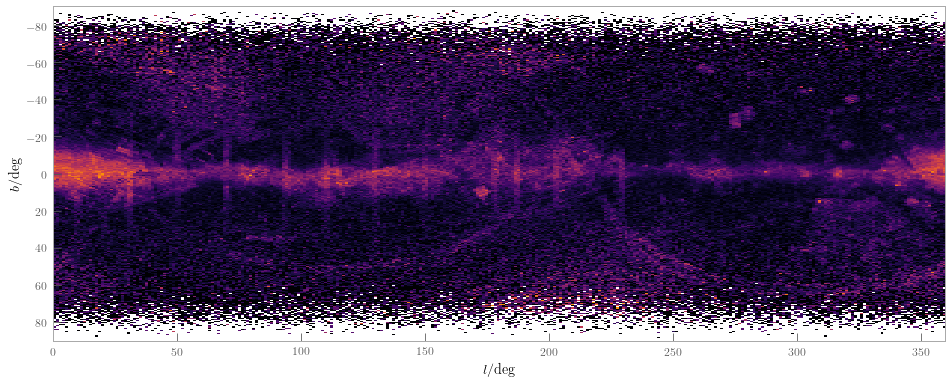

In [271]:
fig = plot_density_fraction("l", "b", N_bins=300,
                            xlabel=r"$l / \mathrm{deg}$",
                            ylabel=r"$b / \mathrm{deg}$",
                            aspect=0.75, colorbar=False, figsize=(16, 8))
